In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [3]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [4]:
from torchvision import transforms

def get_mean_std(loader):
    # Compute the mean and standard deviation of all pixels in the dataset
    num_pixels = 0
    mean = 0.0
    std = 0.0
    for images, _ in loader:
        batch_size, num_channels, height, width = images.shape
        num_pixels += batch_size * height * width
        mean += images.mean(axis=(0, 2, 3)).sum()
        std += images.std(axis=(0, 2, 3)).sum()

    mean /= num_pixels
    std /= num_pixels

    return mean, std

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

batch_size = 64
train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
mean, std = get_mean_std(train_loader)


In [5]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1308,), (0.3081,))
])

training = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=data_transforms,
)

testing = datasets.MNIST(
    root="data",
    train=True,
    download=False,
    transform=data_transforms,
)


In [6]:
images, labels = next(iter(train_loader))  # Get one batch
print(images.shape, labels.shape)  # Expected: (batch_size, 1, 28, 28), (batch_size)

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [8]:
import os
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [9]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [10]:
from torch import nn

learning_rate = 1e-3
batch_size = 64
epochs = 5

In [11]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 12
for t in range(epochs):
    print(f'Epoch {t+1}\n--------------------------------------')
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(test_loader, model, loss_fn)
print('Done!')

Epoch 1
--------------------------------------
loss: 2.303183  [   64/60000]
loss: 2.292202  [ 6464/60000]
loss: 2.301175  [12864/60000]
loss: 2.292846  [19264/60000]
loss: 2.287432  [25664/60000]
loss: 2.287675  [32064/60000]
loss: 2.285464  [38464/60000]
loss: 2.263934  [44864/60000]
loss: 2.275370  [51264/60000]
loss: 2.258931  [57664/60000]
Test Error: 
 Accuracy: 39.2%, Avg loss: 2.261051 

Epoch 2
--------------------------------------
loss: 2.256676  [   64/60000]
loss: 2.259790  [ 6464/60000]
loss: 2.250911  [12864/60000]
loss: 2.254636  [19264/60000]
loss: 2.232683  [25664/60000]
loss: 2.228674  [32064/60000]
loss: 2.239135  [38464/60000]
loss: 2.213770  [44864/60000]
loss: 2.193835  [51264/60000]
loss: 2.191413  [57664/60000]
Test Error: 
 Accuracy: 59.6%, Avg loss: 2.197659 

Epoch 3
--------------------------------------
loss: 2.186944  [   64/60000]
loss: 2.183985  [ 6464/60000]
loss: 2.172227  [12864/60000]
loss: 2.169058  [19264/60000]
loss: 2.175971  [25664/60000]
loss:

In [13]:
for X, y in train_loader:
    print(X.shape)  # Should be [batch_size, 1, 28, 28]
    break


torch.Size([64, 1, 28, 28])


In [14]:
torch.save(model, 'mnist.pth')
print('Model saved successfully!')

Model saved successfully!


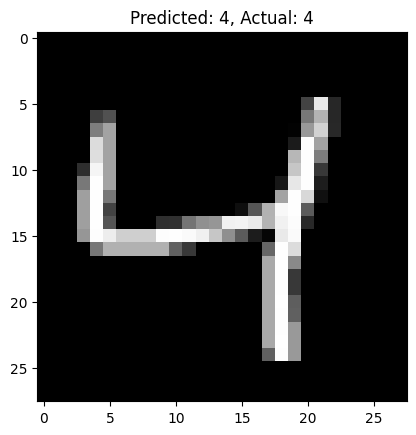

In [15]:
import matplotlib.pyplot as plt

test_image, test_label = testing[2] 
test_image = test_image.unsqueeze(2) 

test_image = test_image.to(device)
model.to(device)

model.eval() 
with torch.no_grad():
    output = model(test_image)

predicted_label = output.argmax(1).item()

plt.imshow(test_image.cpu().squeeze(), cmap="gray")
plt.title(f"Predicted: {predicted_label}, Actual: {test_label}")
plt.show()
